In [1]:
import joblib

#joblib.parallel_backend("threading")

In [2]:
"""
%cd /kaggle/working
#!git clone https://github.com/R-N/ml-utility-loss
%cd ml-utility-loss
!git pull
#!pip install .
!pip install . --no-deps --force-reinstall --upgrade
#"""

'\n%cd /kaggle/working\n#!git clone https://github.com/R-N/ml-utility-loss\n%cd ml-utility-loss\n!git pull\n#!pip install .\n!pip install . --no-deps --force-reinstall --upgrade\n#'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

In [4]:
datasets = [
    "insurance",
    "treatment",
    "contraceptive"
]

study_dir = "./"

In [5]:
#Parameters
import os

path_prefix = "../../../../"

dataset_dir = os.path.join(path_prefix, "ml-utility-loss/datasets")
dataset_name = "treatment"
model_name="ml_utility_2"
models = ["tvae", "realtabformer", "lct_gan", "tab_ddpm_concat"]
single_model = "lct_gan"
random_seed = 42
gp = True
gp_multiply = True
folder = "eval"
debug = False
path = None
param_index = 0
allow_same_prediction = False

In [6]:
# Parameters
dataset = "insurance"
dataset_name = "insurance"
single_model = "tvae"
gp = False
gp_multiply = False
random_seed = 4
debug = False
folder = "eval"
path_prefix = "../../../../"
path = "eval/insurance/tvae/4"
param_index = 2
allow_same_prediction = True


In [7]:
from pathlib import Path
import os

%cd /kaggle/working/

if path is None:
    path = os.path.join(folder, dataset_name, single_model, random_seed)
Path(path).mkdir(parents=True, exist_ok=True)

%cd {path}

/kaggle/working
/kaggle/working/eval/insurance/tvae/4


In [8]:
from ml_utility_loss.util import seed
if single_model:
    model_name=f"{model_name}_{single_model}"
if random_seed is not None:
    seed(random_seed)
    print("Set seed to", seed)

Set seed to <function seed at 0x78d0ad63a320>


In [9]:
import pandas as pd
import numpy as np
import json
import os

df = pd.read_csv(os.path.join(dataset_dir, f"{dataset_name}.csv"))
with open(os.path.join(dataset_dir, f"{dataset_name}.json")) as f:
    info = json.load(f)

In [10]:
task = info["task"]
target = info["target"]
cat_features = info["cat_features"]
mixed_features = info["mixed_features"]
longtail_features = info["longtail_features"]
integer_features = info["integer_features"]

test = df.sample(frac=0.2, random_state=42)
train = df[~df.index.isin(test.index)]

In [11]:
import ml_utility_loss.synthesizers.tab_ddpm.params as TAB_DDPM_PARAMS
import ml_utility_loss.synthesizers.lct_gan.params as LCT_GAN_PARAMS
import ml_utility_loss.synthesizers.realtabformer.params as RTF_PARAMS
from ml_utility_loss.synthesizers.realtabformer.params.default import GPT2_PARAMS, REALTABFORMER_PARAMS
from ml_utility_loss.util import filter_dict_2, filter_dict

tab_ddpm_params = getattr(TAB_DDPM_PARAMS, dataset_name).BEST
lct_gan_params = getattr(LCT_GAN_PARAMS, dataset_name).BEST
lct_ae_params = filter_dict_2(lct_gan_params, LCT_GAN_PARAMS.default.AE_PARAMS)
rtf_params = getattr(RTF_PARAMS, dataset_name).BEST
rtf_params = filter_dict(rtf_params, REALTABFORMER_PARAMS)

lct_ae_embedding_size=lct_gan_params["embedding_size"]
tab_ddpm_normalization="quantile"
tab_ddpm_cat_encoding=tab_ddpm_params["cat_encoding"]
#tab_ddpm_cat_encoding="one-hot"
tab_ddpm_y_policy="default"
tab_ddpm_is_y_cond=True

In [12]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_lct_ae

lct_ae = load_lct_ae(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="lct_ae",
    df_name="df",
)
lct_ae = None

2024-02-29 17:50:48.176006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 17:50:48.176066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 17:50:48.177642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_rtf_embed

rtf_embed = load_rtf_embed(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="realtabformer",
    df_name="df",
    ckpt_type="best-disc-model"
)

In [14]:
from ml_utility_loss.loss_learning.estimator.preprocessing import DataPreprocessor

preprocessor = DataPreprocessor(
    task,
    target=target,
    cat_features=cat_features,
    mixed_features=mixed_features,
    longtail_features=longtail_features,
    integer_features=integer_features,
    lct_ae_embedding_size=lct_ae_embedding_size,
    lct_ae_params=lct_ae_params,
    lct_ae=lct_ae,
    tab_ddpm_normalization=tab_ddpm_normalization,
    tab_ddpm_cat_encoding=tab_ddpm_cat_encoding,
    tab_ddpm_y_policy=tab_ddpm_y_policy,
    tab_ddpm_is_y_cond=tab_ddpm_is_y_cond,
    realtabformer_embedding=rtf_embed,
    realtabformer_params=rtf_params,
)
preprocessor.fit(df)

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
preprocessor.adapter_sizes

{'tvae': 36,
 'realtabformer': (19, 551, Embedding(551, 800), True),
 'lct_gan': 29,
 'tab_ddpm_concat': 12}

In [16]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_3_factory

datasetsn = load_dataset_3_factory(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    cache_dir=path_prefix,
)


In [17]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset

test_set = load_dataset(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/", "datasets_5", dataset_name),
    preprocessor=preprocessor,
    cache_dir=os.path.join(path_prefix, dataset_name, "_cache_test"),
    start=200,
    #stop=600,
    val=False,
    ratio=0,
    drop_first_column=True,
    model=single_model,
)

Caching in ../../../../insurance/_cache_test/tvae/all inf False


In [18]:
import ml_utility_loss.loss_learning.estimator.params2 as PARAMS
from ml_utility_loss.tuning import map_parameters
from ml_utility_loss.loss_learning.estimator.params.default import update_param_space, update_param_space_2
import wandb

#"""
param_space = {
    **getattr(PARAMS, dataset_name).PARAM_SPACE,
}
params = {
    **getattr(PARAMS, dataset_name).BESTS[param_index],
}
if gp:
    params["gradient_penalty_mode"] = "ALL"
    params["mse_mag"] = True
    if gp_multiply:
        params["mse_mag_multiply"] = True
        params["mse_mag_target"] = 1.0
    else:
        params["mse_mag_multiply"] = False
        params["mse_mag_target"] = 0.1
else:
    params["gradient_penalty_mode"] = "NONE"
    params["mse_mag"] = False
params["single_model"] = False
if models:
    params["models"] = models
if single_model:
    params["fixed_role_model"] = single_model
    params["single_model"] = True
    params["models"] = [single_model]
if params["fixed_role_model"] == "realtabformer" and dataset_name == "treatment":
    params["batch_size"] = 2
params["max_seconds"] = 3600
params["patience"] = 10
params["epochs"] = 100
if debug:
    params["epochs"] = 2
with open("params.json", "w") as f:
    json.dump(params, f)
params = map_parameters(params, param_space=param_space)
params

{'Body': 'twin_encoder',
 'loss_balancer_meta': True,
 'loss_balancer_log': False,
 'loss_balancer_lbtw': False,
 'pma_skip_small': False,
 'isab_skip_small': False,
 'layer_norm': False,
 'pma_layer_norm': False,
 'attn_residual': True,
 'tf_n_layers_dec': False,
 'tf_isab_rank': 0,
 'tf_layer_norm': False,
 'tf_pma_start': -1,
 'head_n_seeds': 0,
 'tf_pma_low': 16,
 'dropout': 0,
 'combine_mode': 'diff_left',
 'tf_isab_mode': 'separate',
 'grad_loss_fn': <function torch.nn.functional.l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>,
 'single_model': True,
 'bias': True,
 'bias_final': True,
 'pma_ffn_mode': 'shared',
 'patience': 10,
 'inds_init_mode': 'fixnorm',
 'grad_clip': 0.77,
 'head_final_mul': 'identity',
 'gradient_penalty_mode': {'gradient_penalty': False,
  'calc_grad_m': False,
  'avg_non_role_model_m': False,
  'inverse_avg_non_role_model_m': False},
 'synth_da

In [19]:
train_set, val_set = datasetsn(model=params["fixed_role_model"], synth_data=params["synth_data"])

load_dataset_3_factory 2
Caching in ../../../../insurance/_cache/tvae/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_2/insurance [80, 20]
Caching in ../../../../insurance/_cache4/tvae/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_4/insurance [80, 20]
Caching in ../../../../insurance/_cache5/tvae/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/datasets_5/insurance [160, 40]
[320, 80]
[320, 80]


In [20]:
from ml_utility_loss.loss_learning.estimator.model.pipeline import remove_non_model_params
from ml_utility_loss.loss_learning.estimator.pipeline import create_model
from ml_utility_loss.util import filter_dict, clear_memory

clear_memory()

params2 = remove_non_model_params(params)
adapters = filter_dict(preprocessor.adapter_sizes, params["models"])

model = create_model(
    adapters=adapters,
    #Body="twin_encoder",
    **params2,
)
#cf.apply_weight_standardization(model, n_last_layers_ignore=0)
print(model.models, len(model.adapters))

Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>


[*] Embedding False True
['tvae'] 1


In [21]:
study_name=f"{model_name}_{dataset_name}"

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

9638529

In [23]:
from torchinfo import summary

role_model = params["fixed_role_model"]
s = train_set[0][role_model]
summary(model[role_model], input_size=((2, *s[0].shape), (2, *s[1].shape)), depth=9) # 8 max

Layer (type:depth-idx)                                                 Output Shape              Param #
MLUtilitySingle                                                        [2, 1071, 36]             --
├─Adapter: 1-1                                                         [2, 1071, 36]             --
│    └─Sequential: 2-1                                                 [2, 1071, 256]            --
│    │    └─FeedForward: 3-1                                           [2, 1071, 1024]           --
│    │    │    └─Linear: 4-1                                           [2, 1071, 1024]           37,888
│    │    │    └─ReLU: 4-2                                             [2, 1071, 1024]           --
│    │    └─FeedForward: 3-2                                           [2, 1071, 1024]           --
│    │    │    └─Linear: 4-3                                           [2, 1071, 1024]           1,049,600
│    │    │    └─ReLU: 4-4                                             [2, 1071, 102

In [24]:
import torch
from ml_utility_loss.loss_learning.estimator.pipeline import train, train_2
from ml_utility_loss.loss_learning.estimator.process_simple import train_epoch, eval as _eval
from ml_utility_loss.params import GradientPenaltyMode
from ml_utility_loss.util import clear_memory
import time
#torch.autograd.set_detect_anomaly(True)

clear_memory()

opt = params["Optim"](model.parameters())
loss = train_2(
    [train_set, val_set, test_set],
    preprocessor=preprocessor,
    whole_model=model,
    optim=opt,
    log_dir="logs",
    checkpoint_dir="checkpoints",
    verbose=True,
    allow_same_prediction=allow_same_prediction,
    wandb=wandb,
    study_name=study_name,
    **params
)

wandb: Tracking run with wandb version 0.16.3


wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


g_loss_mul 0.1
Epoch 0


Train loss {'avg_role_model_loss': 0.05458167113538366, 'avg_role_model_std_loss': 4.561985811768864, 'avg_role_model_mean_pred_loss': 0.023550471702759836, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.05458167113538366, 'n_size': 320, 'n_batch': 40, 'duration': 39.33485436439514, 'duration_batch': 0.9833713591098785, 'duration_size': 0.12292141988873481, 'avg_pred_std': 0.12334999229060487}


Val loss {'avg_role_model_loss': 0.01106511988909915, 'avg_role_model_std_loss': 7.3775769050087545, 'avg_role_model_mean_pred_loss': 0.00039846873109325995, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.01106511988909915, 'n_size': 80, 'n_batch': 10, 'duration': 8.30074167251587, 'duration_batch': 0.8300741672515869, 'duration_size': 0.10375927090644836, 'avg_pred_std': 0.04176213040482253}
Epoch 1


Train loss {'avg_role_model_loss': 0.010921533098735382, 'avg_role_model_std_loss': 3.7708608118317897, 'avg_role_model_mean_pred_loss': 0.0006090835865870864, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.010921533098735382, 'n_size': 320, 'n_batch': 40, 'duration': 38.92951965332031, 'duration_batch': 0.9732379913330078, 'duration_size': 0.12165474891662598, 'avg_pred_std': 0.07502402040408924}


Val loss {'avg_role_model_loss': 0.002461973318713717, 'avg_role_model_std_loss': 0.2656627141033823, 'avg_role_model_mean_pred_loss': 8.382165523856955e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002461973318713717, 'n_size': 80, 'n_batch': 10, 'duration': 8.352109670639038, 'duration_batch': 0.8352109670639039, 'duration_size': 0.10440137088298798, 'avg_pred_std': 0.07963283583521844}
Epoch 2


Train loss {'avg_role_model_loss': 0.004752650485897902, 'avg_role_model_std_loss': 4.5005246672456, 'avg_role_model_mean_pred_loss': 7.41932757047259e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.004752650485897902, 'n_size': 320, 'n_batch': 40, 'duration': 39.09458088874817, 'duration_batch': 0.9773645222187042, 'duration_size': 0.12217056527733802, 'avg_pred_std': 0.0816895533236675}


Val loss {'avg_role_model_loss': 0.0009612412060960196, 'avg_role_model_std_loss': 0.23112409779214432, 'avg_role_model_mean_pred_loss': 2.9920761611550857e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0009612412060960196, 'n_size': 80, 'n_batch': 10, 'duration': 8.301867723464966, 'duration_batch': 0.8301867723464966, 'duration_size': 0.10377334654331208, 'avg_pred_std': 0.08093988439068198}
Epoch 3


Train loss {'avg_role_model_loss': 0.0029934452861198222, 'avg_role_model_std_loss': 1.4091149369219238, 'avg_role_model_mean_pred_loss': 3.706777377407988e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0029934452861198222, 'n_size': 320, 'n_batch': 40, 'duration': 39.057528257369995, 'duration_batch': 0.9764382064342498, 'duration_size': 0.12205477580428123, 'avg_pred_std': 0.08644149880856275}


Val loss {'avg_role_model_loss': 0.0017080451536457986, 'avg_role_model_std_loss': 0.5054739748910834, 'avg_role_model_mean_pred_loss': 2.0698145459556274e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0017080451536457986, 'n_size': 80, 'n_batch': 10, 'duration': 8.39680528640747, 'duration_batch': 0.839680528640747, 'duration_size': 0.10496006608009338, 'avg_pred_std': 0.0637943553738296}
Epoch 4


Train loss {'avg_role_model_loss': 0.0022114409464847997, 'avg_role_model_std_loss': 1.4571088086362807, 'avg_role_model_mean_pred_loss': 9.073904502000795e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0022114409464847997, 'n_size': 320, 'n_batch': 40, 'duration': 38.94040822982788, 'duration_batch': 0.973510205745697, 'duration_size': 0.12168877571821213, 'avg_pred_std': 0.08093992052599788}


Val loss {'avg_role_model_loss': 0.0034676186623983085, 'avg_role_model_std_loss': 0.354912094264597, 'avg_role_model_mean_pred_loss': 1.1135635656955855e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0034676186623983085, 'n_size': 80, 'n_batch': 10, 'duration': 8.30032467842102, 'duration_batch': 0.830032467842102, 'duration_size': 0.10375405848026276, 'avg_pred_std': 0.10819654231891036}
Epoch 5


Train loss {'avg_role_model_loss': 0.0016322427756676916, 'avg_role_model_std_loss': 0.8344269889868698, 'avg_role_model_mean_pred_loss': 2.8054938205387956e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0016322427756676916, 'n_size': 320, 'n_batch': 40, 'duration': 39.14137244224548, 'duration_batch': 0.9785343110561371, 'duration_size': 0.12231678888201714, 'avg_pred_std': 0.09135764897800983}


Val loss {'avg_role_model_loss': 0.0034494245337555185, 'avg_role_model_std_loss': 2.7931900787574704, 'avg_role_model_mean_pred_loss': 6.050434956339501e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0034494245337555185, 'n_size': 80, 'n_batch': 10, 'duration': 8.366892337799072, 'duration_batch': 0.8366892337799072, 'duration_size': 0.1045861542224884, 'avg_pred_std': 0.055338869569823146}
Epoch 6


Train loss {'avg_role_model_loss': 0.002849590677578817, 'avg_role_model_std_loss': 0.8129531741204119, 'avg_role_model_mean_pred_loss': 4.8211906484207924e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002849590677578817, 'n_size': 320, 'n_batch': 40, 'duration': 38.968292236328125, 'duration_batch': 0.9742073059082031, 'duration_size': 0.1217759132385254, 'avg_pred_std': 0.0901852805633098}


Val loss {'avg_role_model_loss': 0.0025212633569026365, 'avg_role_model_std_loss': 0.6178526908131061, 'avg_role_model_mean_pred_loss': 1.4414640320481454e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0025212633569026365, 'n_size': 80, 'n_batch': 10, 'duration': 8.266654014587402, 'duration_batch': 0.8266654014587402, 'duration_size': 0.10333317518234253, 'avg_pred_std': 0.05773084256798029}
Epoch 7


Train loss {'avg_role_model_loss': 0.0034268524424987843, 'avg_role_model_std_loss': 1.5629836895840525, 'avg_role_model_mean_pred_loss': 1.5161425290398687e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0034268524424987843, 'n_size': 320, 'n_batch': 40, 'duration': 39.01256036758423, 'duration_batch': 0.9753140091896058, 'duration_size': 0.12191425114870072, 'avg_pred_std': 0.0829970414401032}


Val loss {'avg_role_model_loss': 0.0014418774226214737, 'avg_role_model_std_loss': 0.05386366389284376, 'avg_role_model_mean_pred_loss': 2.4331560492640845e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0014418774226214737, 'n_size': 80, 'n_batch': 10, 'duration': 8.32570481300354, 'duration_batch': 0.832570481300354, 'duration_size': 0.10407131016254426, 'avg_pred_std': 0.08880755109712482}
Epoch 8


Train loss {'avg_role_model_loss': 0.0016761758448410546, 'avg_role_model_std_loss': 0.571136603817564, 'avg_role_model_mean_pred_loss': 7.011435811053887e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0016761758448410546, 'n_size': 320, 'n_batch': 40, 'duration': 38.852670669555664, 'duration_batch': 0.9713167667388916, 'duration_size': 0.12141459584236144, 'avg_pred_std': 0.09045831263065338}


Val loss {'avg_role_model_loss': 0.0006263804327318212, 'avg_role_model_std_loss': 0.24181758030463243, 'avg_role_model_mean_pred_loss': 6.295153740953907e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0006263804327318212, 'n_size': 80, 'n_batch': 10, 'duration': 8.345160722732544, 'duration_batch': 0.8345160722732544, 'duration_size': 0.1043145090341568, 'avg_pred_std': 0.08191414531320333}
Epoch 9


Train loss {'avg_role_model_loss': 0.0008744017197386711, 'avg_role_model_std_loss': 0.17949836104246067, 'avg_role_model_mean_pred_loss': 4.63043962907906e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0008744017197386711, 'n_size': 320, 'n_batch': 40, 'duration': 39.11712980270386, 'duration_batch': 0.9779282450675965, 'duration_size': 0.12224103063344956, 'avg_pred_std': 0.09466907754540443}


Val loss {'avg_role_model_loss': 0.0011390350133297033, 'avg_role_model_std_loss': 0.004834387120854444, 'avg_role_model_mean_pred_loss': 3.0137808032293377e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0011390350133297033, 'n_size': 80, 'n_batch': 10, 'duration': 8.316069841384888, 'duration_batch': 0.8316069841384888, 'duration_size': 0.1039508730173111, 'avg_pred_std': 0.0990539627149701}
Epoch 10


Train loss {'avg_role_model_loss': 0.0004748740824652486, 'avg_role_model_std_loss': 0.1777749692730623, 'avg_role_model_mean_pred_loss': 2.3089836414527056e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0004748740824652486, 'n_size': 320, 'n_batch': 40, 'duration': 39.06293201446533, 'duration_batch': 0.9765733003616333, 'duration_size': 0.12207166254520416, 'avg_pred_std': 0.09201494687004015}


Val loss {'avg_role_model_loss': 0.00032443252712255344, 'avg_role_model_std_loss': 0.0010629200933180982, 'avg_role_model_mean_pred_loss': 3.426863805611191e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00032443252712255344, 'n_size': 80, 'n_batch': 10, 'duration': 8.351998329162598, 'duration_batch': 0.8351998329162598, 'duration_size': 0.10439997911453247, 'avg_pred_std': 0.0884638118557632}
Epoch 11


Train loss {'avg_role_model_loss': 0.00030916042924218347, 'avg_role_model_std_loss': 0.04881817966124018, 'avg_role_model_mean_pred_loss': 2.0088672352989394e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00030916042924218347, 'n_size': 320, 'n_batch': 40, 'duration': 38.86811137199402, 'duration_batch': 0.9717027842998505, 'duration_size': 0.12146284803748131, 'avg_pred_std': 0.10129309091717005}


Val loss {'avg_role_model_loss': 0.00028257269877940416, 'avg_role_model_std_loss': 1.0737754437432159, 'avg_role_model_mean_pred_loss': 2.8357685949442768e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00028257269877940416, 'n_size': 80, 'n_batch': 10, 'duration': 8.252684354782104, 'duration_batch': 0.8252684354782105, 'duration_size': 0.10315855443477631, 'avg_pred_std': 0.08038602282758803}
Epoch 12


Train loss {'avg_role_model_loss': 0.0013487103491570452, 'avg_role_model_std_loss': 0.43372808683234754, 'avg_role_model_mean_pred_loss': 1.0047366970687786e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0013487103491570452, 'n_size': 320, 'n_batch': 40, 'duration': 39.09407997131348, 'duration_batch': 0.9773519992828369, 'duration_size': 0.12216899991035461, 'avg_pred_std': 0.0899976636399515}


Val loss {'avg_role_model_loss': 0.003439919964876026, 'avg_role_model_std_loss': 0.015614798056776635, 'avg_role_model_mean_pred_loss': 2.0251521429592856e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003439919964876026, 'n_size': 80, 'n_batch': 10, 'duration': 8.342942476272583, 'duration_batch': 0.8342942476272583, 'duration_size': 0.1042867809534073, 'avg_pred_std': 0.11240037991665304}
Epoch 13


Train loss {'avg_role_model_loss': 0.0008618889094577753, 'avg_role_model_std_loss': 0.1384840221481113, 'avg_role_model_mean_pred_loss': 4.446653539750059e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0008618889094577753, 'n_size': 320, 'n_batch': 40, 'duration': 38.886531829833984, 'duration_batch': 0.9721632957458496, 'duration_size': 0.1215204119682312, 'avg_pred_std': 0.09283134532161057}


Val loss {'avg_role_model_loss': 0.000532695987567422, 'avg_role_model_std_loss': 0.6308531300281175, 'avg_role_model_mean_pred_loss': 1.360833180625437e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.000532695987567422, 'n_size': 80, 'n_batch': 10, 'duration': 8.28925633430481, 'duration_batch': 0.828925633430481, 'duration_size': 0.10361570417881012, 'avg_pred_std': 0.0891546759288758}
Epoch 14


Train loss {'avg_role_model_loss': 0.00030356911156559363, 'avg_role_model_std_loss': 0.3619111133062688, 'avg_role_model_mean_pred_loss': 5.198837278813596e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00030356911156559363, 'n_size': 320, 'n_batch': 40, 'duration': 38.988784074783325, 'duration_batch': 0.9747196018695832, 'duration_size': 0.1218399502336979, 'avg_pred_std': 0.09746413570828735}


Val loss {'avg_role_model_loss': 0.0005432431978988461, 'avg_role_model_std_loss': 0.001004549844947178, 'avg_role_model_mean_pred_loss': 2.781989758560144e-07, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0005432431978988461, 'n_size': 80, 'n_batch': 10, 'duration': 8.42578673362732, 'duration_batch': 0.842578673362732, 'duration_size': 0.1053223341703415, 'avg_pred_std': 0.09348368076607586}
Epoch 15


Train loss {'avg_role_model_loss': 0.00029625174347529536, 'avg_role_model_std_loss': 0.0572095896306493, 'avg_role_model_mean_pred_loss': 6.03426183574306e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00029625174347529536, 'n_size': 320, 'n_batch': 40, 'duration': 39.27268958091736, 'duration_batch': 0.981817239522934, 'duration_size': 0.12272715494036675, 'avg_pred_std': 0.09890737304231152}


Val loss {'avg_role_model_loss': 0.00036838351952610536, 'avg_role_model_std_loss': 0.7212186768025276, 'avg_role_model_mean_pred_loss': 2.6941624464704718e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00036838351952610536, 'n_size': 80, 'n_batch': 10, 'duration': 8.407346963882446, 'duration_batch': 0.8407346963882446, 'duration_size': 0.10509183704853058, 'avg_pred_std': 0.08277125156018883}
Epoch 16


Train loss {'avg_role_model_loss': 0.0005824315209792986, 'avg_role_model_std_loss': 0.32841089839253074, 'avg_role_model_mean_pred_loss': 9.46431564320671e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0005824315209792986, 'n_size': 320, 'n_batch': 40, 'duration': 39.24979209899902, 'duration_batch': 0.9812448024749756, 'duration_size': 0.12265560030937195, 'avg_pred_std': 0.09515800991794095}


Val loss {'avg_role_model_loss': 0.0007761759276036173, 'avg_role_model_std_loss': 1.2551941490234082, 'avg_role_model_mean_pred_loss': 2.9720144345546373e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0007761759276036173, 'n_size': 80, 'n_batch': 10, 'duration': 8.318324089050293, 'duration_batch': 0.8318324089050293, 'duration_size': 0.10397905111312866, 'avg_pred_std': 0.09093907248461619}
Epoch 17


Train loss {'avg_role_model_loss': 0.0012332158104982228, 'avg_role_model_std_loss': 0.6590279597393532, 'avg_role_model_mean_pred_loss': 8.36102873709775e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0012332158104982228, 'n_size': 320, 'n_batch': 40, 'duration': 39.119892835617065, 'duration_batch': 0.9779973208904267, 'duration_size': 0.12224966511130334, 'avg_pred_std': 0.0890660552540794}


Val loss {'avg_role_model_loss': 0.001825959722918924, 'avg_role_model_std_loss': 1.9564546512207017, 'avg_role_model_mean_pred_loss': 1.1242688799484313e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.001825959722918924, 'n_size': 80, 'n_batch': 10, 'duration': 8.359159708023071, 'duration_batch': 0.8359159708023072, 'duration_size': 0.1044894963502884, 'avg_pred_std': 0.06533113070763648}
Epoch 18


Train loss {'avg_role_model_loss': 0.001502491006613127, 'avg_role_model_std_loss': 0.4666562590015076, 'avg_role_model_mean_pred_loss': 3.179587947280127e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.001502491006613127, 'n_size': 320, 'n_batch': 40, 'duration': 39.09075927734375, 'duration_batch': 0.9772689819335938, 'duration_size': 0.12215862274169922, 'avg_pred_std': 0.09002331190858967}


Val loss {'avg_role_model_loss': 0.0008729565364774316, 'avg_role_model_std_loss': 0.20973070683976403, 'avg_role_model_mean_pred_loss': 2.998759428507469e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0008729565364774316, 'n_size': 80, 'n_batch': 10, 'duration': 8.317886352539062, 'duration_batch': 0.8317886352539062, 'duration_size': 0.10397357940673828, 'avg_pred_std': 0.08415974881500006}
Epoch 19


Train loss {'avg_role_model_loss': 0.001246437881127349, 'avg_role_model_std_loss': 0.6120949116166994, 'avg_role_model_mean_pred_loss': 2.0787087329172948e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.001246437881127349, 'n_size': 320, 'n_batch': 40, 'duration': 39.05946326255798, 'duration_batch': 0.9764865815639496, 'duration_size': 0.1220608226954937, 'avg_pred_std': 0.09171894917380996}


Val loss {'avg_role_model_loss': 0.002248370127927046, 'avg_role_model_std_loss': 4.686978222953622, 'avg_role_model_mean_pred_loss': 2.895269359082242e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002248370127927046, 'n_size': 80, 'n_batch': 10, 'duration': 8.319932222366333, 'duration_batch': 0.8319932222366333, 'duration_size': 0.10399915277957916, 'avg_pred_std': 0.0715100662317127}
Epoch 20


Train loss {'avg_role_model_loss': 0.0029011325517785736, 'avg_role_model_std_loss': 0.9372176351432528, 'avg_role_model_mean_pred_loss': 1.1204305509332328e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0029011325517785736, 'n_size': 320, 'n_batch': 40, 'duration': 38.93023109436035, 'duration_batch': 0.9732557773590088, 'duration_size': 0.1216569721698761, 'avg_pred_std': 0.08712862803367898}


Val loss {'avg_role_model_loss': 0.0013807336257741555, 'avg_role_model_std_loss': 2.265311992234274, 'avg_role_model_mean_pred_loss': 1.8232192309453056e-06, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0013807336257741555, 'n_size': 80, 'n_batch': 10, 'duration': 8.43259859085083, 'duration_batch': 0.843259859085083, 'duration_size': 0.10540748238563538, 'avg_pred_std': 0.07126395150553436}
Epoch 21


Train loss {'avg_role_model_loss': 0.0005831055974340416, 'avg_role_model_std_loss': 0.7094658932399625, 'avg_role_model_mean_pred_loss': 5.484142581780628e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0005831055974340416, 'n_size': 320, 'n_batch': 40, 'duration': 38.932344913482666, 'duration_batch': 0.9733086228370667, 'duration_size': 0.12166357785463333, 'avg_pred_std': 0.09576541467686184}


wandb:                                                                                


Val loss {'avg_role_model_loss': 0.00040745751502981877, 'avg_role_model_std_loss': 0.01960964320030456, 'avg_role_model_mean_pred_loss': 8.632079813164495e-08, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.00040745751502981877, 'n_size': 80, 'n_batch': 10, 'duration': 8.343457698822021, 'duration_batch': 0.8343457698822021, 'duration_size': 0.10429322123527526, 'avg_pred_std': 0.0816122055053711}
Stopped False


wandb: 
wandb: Run history:
wandb:                       avg_loss_test █▂▁▂▃▃▂▂▁▂▁▁▃▁▁▁▁▂▁▂▂▁
wandb:                      avg_loss_train █▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_embed_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_embed_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_g_cos_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_g_cos_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:  avg_non_role_model_g_mag_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: avg_non_role_model_g_mag_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:                   avg_pred_std_test ▁▅▅▃█▂▃▆▅▇▆▅█▆▆▅▆▃▅▄▄▅
wandb:                  avg_pred_std_train █▁▂▃▂▃▃▂▃▄▃▅▃▄▄▄▄▃▃▃▃▄
wandb:      avg_role_model_g_cos_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     avg_role_model_g_cos_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:      avg_role_model_g_mag_loss_test ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:     avg_role_model_g_mag_loss_train ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:            avg_role_model_loss_test █▂▁▂▃

wandb: You can sync this run to the cloud by running:
wandb: wandb sync /kaggle/working/eval/insurance/tvae/4/wandb/offline-run-20240229_175101-y38e2cwk


wandb: Find logs at: ./wandb/offline-run-20240229_175101-y38e2cwk/logs


Eval loss {'role_model': 'tvae', 'n_size': 399, 'n_batch': 50, 'role_model_metrics': {'avg_loss': 0.00027497335946021655, 'avg_g_mag_loss': 0.044538616604244054, 'avg_g_cos_loss': 0.14042933068628, 'pred_duration': 0.8693411350250244, 'grad_duration': 0.5576837062835693, 'total_duration': 1.4270248413085938, 'pred_std': 0.15040387213230133, 'std_loss': 0.0008385280380025506, 'mean_pred_loss': 1.3921320984877639e-08, 'pred_rmse': 0.016582321375608444, 'pred_mae': 0.012896367348730564, 'pred_mape': 0.13851648569107056, 'grad_rmse': 0.034425459802150726, 'grad_mae': 0.018821561709046364, 'grad_mape': 0.6824872493743896}, 'non_role_model_metrics': {'avg_loss': 0, 'avg_g_mag_loss': 0, 'avg_g_cos_loss': 0, 'avg_pred_duration': 0, 'avg_grad_duration': 0, 'avg_total_duration': 0, 'avg_pred_std': 0, 'avg_std_loss': 0, 'avg_mean_pred_loss': 0}, 'avg_metrics': {'avg_loss': 0.00027497335946021655, 'avg_g_mag_loss': 0.044538616604244054, 'avg_g_cos_loss': 0.14042933068628, 'avg_pred_duration': 0.86

In [25]:
model = loss["whole_model"]
opt = loss["optim"]

In [26]:
import torch
from copy import deepcopy

torch.save(deepcopy(model.state_dict()), "model.pt")
#torch.save(deepcopy(opt.state_dict()), "optim.pt")

<Axes: >

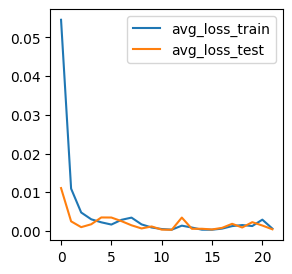

In [27]:
history = loss["history"]
history.to_csv("history.csv")
history[["avg_loss_train", "avg_loss_test"]].plot()

In [28]:

from ml_utility_loss.loss_learning.estimator.pipeline import eval
#eval_loss = loss["eval_loss"]

batch_size = params["batch_size_low"] if "batch_size_low" in params else params["batch_size"]

eval_loss = eval(
    test_set, model,
    batch_size=batch_size,
)

In [29]:
import pandas as pd

metrics = pd.DataFrame(eval_loss["model_metrics"]).T
metrics.to_csv("eval.csv")
metrics

avg_g_cos_loss  avg_g_mag_loss  avg_loss  grad_duration  grad_mae  \
tvae        0.134784        0.036368  0.000275       0.568386  0.018824   

      grad_mape  grad_rmse  mean_pred_loss  pred_duration  pred_mae  \
tvae   0.682566   0.034434    1.392132e-08       0.883704  0.012897   

      pred_mape  pred_rmse  pred_std  std_loss  total_duration  
tvae   0.138517   0.016583  0.150404  0.000839         1.45209

In [30]:
from ml_utility_loss.util import clear_memory
clear_memory()

In [31]:
#"""
from ml_utility_loss.loss_learning.estimator.process import pred, pred_2
from ml_utility_loss.util import stack_samples

#samples = test_set[list(range(len(test_set)))]
#y = {m: pred(model[m], s) for m, s in samples.items()}
y = pred_2(model, test_set, batch_size=batch_size)
#"""

Caching in ../../../../insurance/_cache_test/tvae/all inf False


In [32]:
import os
import pandas as pd
from ml_utility_loss.util import transpose_dict

os.makedirs("pred", exist_ok=True)
y2 = transpose_dict(y)
for k, v in y2.items():
    df = pd.DataFrame(v)
    df.to_csv(f"pred/{k}.csv")

In [33]:
print({k: sum(v["pred"])/len(v["pred"]) for k, v in y.items()})

{'tvae': 0.05389225258396234}


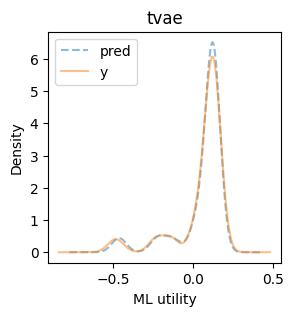

In [34]:
from ml_utility_loss.loss_learning.visualization import plot_pred_density_2

_ = plot_pred_density_2(y)

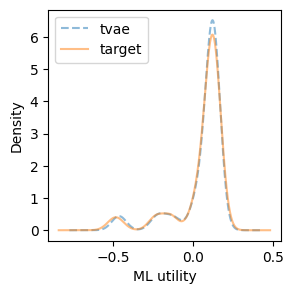

In [35]:
from ml_utility_loss.loss_learning.visualization import plot_density_3

_ = plot_density_3(y2["pred"], next(iter(y2["y"].values())))

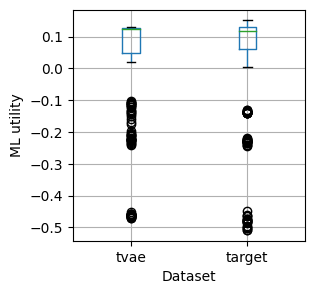

In [36]:
from ml_utility_loss.loss_learning.visualization import plot_box_3

_ = plot_box_3(y2["pred"], next(iter(y2["y"].values())))

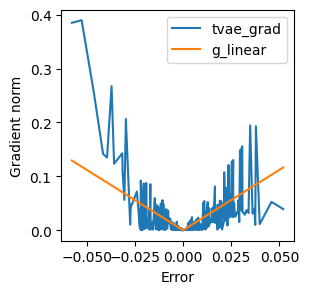

In [37]:
#"""
from ml_utility_loss.loss_learning.visualization import plot_grad, plot_grad_2, plot_grad_3
import matplotlib.pyplot as plt

#plot_grad_2(y, model.models)
for m in model.models:
    ym = y[m]
    fig, ax = plt.subplots()
    plot_grad_3(ym["error"], ym["grad"], name=f"{m}_grad", fig=fig, ax=ax)
#"""